## Quantitaive and qualitative data inspection

In [9]:
# libraries 
import numpy as np
import h5py
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from IPython.display import display
import os
import sys
sys.path.append('../../src')

from utils.evaluate_utils import get_indices

### Qualitative analysis

In [19]:
h5_files = ['../../data/CARDIAC/M5_2mm_step2_static_dynamic.h5','../../data/CARDIAC/M6_2mm_step2_static_dynamic.h5', ]
# h5_files = ['../../results/interpolation/M2_2mm_step1_static_kspace_testTBD.h5', ]
file_label = ['Model5', 'Model6',]

# columns to load from data
colnames = ['u', 'v', 'w',  'mask'] #


# load data
data = {}
for h5_file, label in zip(h5_files, file_label):
    with h5py.File(h5_file, 'r') as f:
        for vel in colnames:
            data[f'{label}_{vel}'] = np.array(f[vel]).squeeze()


In [20]:
#TODO: add vmin and vmax to the plot
# make use to also choose the colname (data) such that magnitude and velocity can be plotted next to each other

# show interactive plot

T, X, Y, Z= data[f'{file_label[0]}_u'].shape

print(T, X, Y, Z)
@widgets.interact(frame=(0, T-1), x = (0, X-1), vel=colnames, axis=[0, 1, 2])
def f(frame=5, x = 10, vel = "u", axis = 0):
    plt.figure(figsize=(7,7))
    N = len(h5_files)
    idxs = get_indices(frame,axis, x)

    for i, t_name in enumerate(file_label):

        plt.subplot(1, N, i+1)
        plt.imshow(data[f'{label}_{vel}'][idxs])#,  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
        plt.title(t_name)
        plt.axis('off')
    

50 70 70 71


interactive(children=(IntSlider(value=5, description='frame', max=49), IntSlider(value=10, description='x', ma…

277.8925
193.45845
201.2068
38317020.483009085


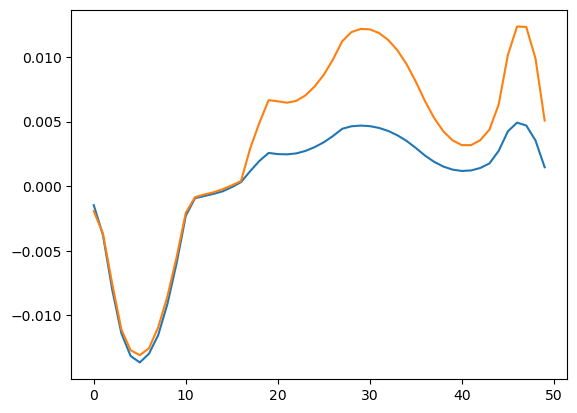

In [25]:
for vel in colnames:
    print(np.linalg.norm(data[f'{file_label[0]}_{vel}'][:, :, :, 1:] - data[f'{file_label[1]}_{vel}']))

plt.plot(np.mean(data[f'{file_label[0]}_u'], axis=(1, 2, 3)), label='Model5')
plt.plot(np.mean(data[f'{file_label[1]}_u'], axis=(1, 2, 3)), label='Model6')


In [18]:

def bbox2_3D(img):
    ''' code copied from https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array'''

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return rmin, rmax, cmin, cmax, zmin, zmax

rmin, rmax, cmin, cmax, zmin, zmax = bbox2_3D(data[f'{file_label[0]}_mask'])

print('mask shape', data[f'{file_label[0]}_mask'].shape[1:])
print(rmin, rmax, cmin, cmax, zmin, zmax)

bbox = np.zeros(data[f'{file_label[0]}_mask'].shape[1:])
bbox[cmin:cmax,zmin:zmax,rmin:rmax] = 1


mask shape (70, 70, 70)
0 49 0 62 0 62


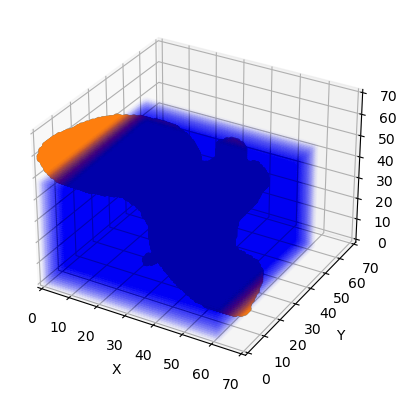

In [17]:
from mpl_toolkits.mplot3d import Axes3D
mask = data[f'{file_label[0]}_mask'].squeeze()[0]

x, y, z = np.where(mask == 1)
x1, y1, z1 = np.where(data[f'{file_label[0]}_u'][0] != 0)
x2, y2, z2 = np.where(bbox == 1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.scatter(x1, y1, z1)
ax.scatter(x2, y2, z2, alpha = 0.01, c ='b')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0, X)
ax.set_ylim(0, Y)
ax.set_zlim(0, Z)
plt.show()

Create gif Animation of data

MovieWriter ffmpeg unavailable; using Pillow instead.


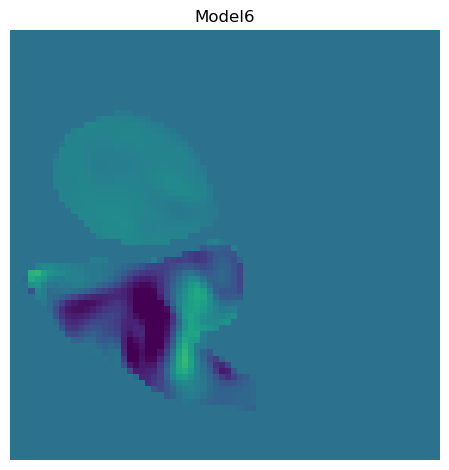

In [8]:
min_v = None
max_v = None

eval_dir = '../../results/interpolation/plots'
if not os.path.exists(eval_dir):
    os.makedirs(eval_dir)

def create_temporal_comparison_gif_single(idx, data, title):
    N_frames = data.shape[0]
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(data[0, idx, :, :],interpolation='none', vmin=min_v, vmax=max_v)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        return [im1]

    # animation function.  This is called sequentially
    def animate(i):
        im1.set_array(data[i, idx, :, :])
        return [im1]

    anim = animation.FuncAnimation(fig,animate, init_func=init, frames = N_frames,interval = 100, ) # in ms)


    anim.save(f'{eval_dir}/Animate_{title}_single.gif', fps=10)

t, x, y, z = data[f'{file_label[0]}_u'].shape
create_temporal_comparison_gif_single(x//2, data[f'{file_label[0]}_v'], file_label[0])